In [1]:
import numpy as np
import json
from glob import glob
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *

# Data loading and preparation

In [2]:
json_fns = glob("gaze_syn_img//*.json")
all_y = np.zeros((len(json_fns), 3))
all_x = np.zeros((len(json_fns), 384, 512, 3))

i = 0
for json_fn in json_fns:
    img = cv2.imread("%s.jpg"%json_fn[:-5])
    all_x[i,:,:,:] = img
    data = json.load(open(json_fn))
    look_vec = list(eval(data['eye_details']['look_vec']))
    look_vec[1] = -look_vec[1]
    all_y[i,:] = look_vec[:3]
    i = i + 1
    
mean_ = all_y.mean(axis=0)
std_ = all_y.std(axis=0)
all_y = (all_y - mean_) / std_

all_x = all_x / 255
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=42)

all_y = 0
all_x = 0

[ 1.12023678 -1.12488518  0.33141463]


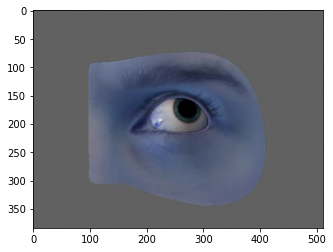

In [9]:
num = 1
plt.imshow(x_train[num,:,:,:])
print(y_train[num,:])

# Build CNN

In [2]:
inputs = layers.Input(shape=(384, 512, 3))
x = layers.Conv2D(64, (3, 3), strides=(2,2), activation="relu", padding="same")(inputs)
x = layers.Conv2D(64, (3, 3), strides=(1,1), activation="relu", padding="same")(x)
x = layers.Conv2D(96, (3, 3), strides=(2,2), activation="relu", padding="same")(x)
x = layers.Conv2D(96, (3, 3), strides=(1,1), activation="relu", padding="same")(x)
x = layers.Conv2D(144, (3, 3), strides=(2,2), activation="relu", padding="same")(x)
x = layers.Conv2D(144, (3, 3), strides=(1,1), activation="relu", padding="same")(x)
x = layers.Conv2D(216, (3, 3), strides=(2,2), activation="relu", padding="same")(x)
x = layers.Conv2D(216, (3, 3), strides=(1,1), activation="relu", padding="same")(x)
x = layers.Conv2D(324, (3, 3), strides=(2,2), activation="relu", padding="same")(x)
x = layers.Conv2D(324, (3, 3), strides=(1,1), activation="relu", padding="same")(x)
x = layers.Conv2D(486, (3, 3), strides=(2,2), activation="relu", padding="same")(x)
x = layers.Conv2D(486, (3, 3), strides=(1,1), activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(units=9720,activation='linear')(x)
x = layers.Dense(units=160,activation='linear')(x)
output = layers.Dense(units=3, activation='linear')(x)

cnn_model = Model(inputs, output)
cnn_model.summary()

EPOCH = 300
learning_rate = 0.01
decay_rate = learning_rate / EPOCH 
optimizer = tf.keras.optimizers.Adam(lr=learning_rate,decay=decay_rate) 
cnn_model.compile(loss='mae',optimizer=optimizer,metrics=['mae'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 256, 64)      36928     
_________________________________________________________________
flatten (Flatten)            (None, 3145728)           0         
_________________________________________________________________
dropout (Dropout)            (None, 3145728)           0         
_________________________________________________________________
dense (Dense)                (None, 160)               503316640 
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [10]:
inputs = layers.Input(shape=(384, 512, 3))
x = layers.Conv2D(64, (3, 3), strides=(2,2), activation="relu", padding="same")(inputs)
x = layers.Conv2D(64, (3, 3), strides=(1,1), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), strides=(2,2), activation="relu", padding="same")(x)
x = layers.Conv2D(32, (3, 3), strides=(1,1), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (3, 3), strides=(2,2), activation="relu", padding="same")(x)
x = layers.Conv2D(16, (3, 3), strides=(2,2), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(units=64,activation='linear', kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.Dense(units=64,activation='linear', kernel_regularizer=regularizers.l2(0.0005))(x)
output = layers.Dense(units=3, activation='linear')(x)

cnn_model = Model(inputs, output)
cnn_model.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 384, 512, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 192, 256, 64)      1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 192, 256, 64)      36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 192, 256, 64)      256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 96, 128, 32)       18464     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 96, 128, 32)       9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 96, 128, 32)      

# Training

In [56]:
EPOCH = 300
learning_rate = 0.01
decay_rate = learning_rate / EPOCH 
optimizer = tf.keras.optimizers.Adam(lr=learning_rate,decay=decay_rate) 
cnn_model.compile(loss='mae',optimizer=optimizer,metrics=['mae'])

cnn_model.fit(
    x = x_train, 
    y = y_train,
    batch_size=32, 
    epochs=EPOCH,
    shuffle=True,
    validation_data=(x_test, y_test))

Epoch 1/300
64/64 [==============================] - 272s 4s/step - loss: 0.5187 - mae: 0.3819 - val_loss: 0.3041 - val_mae: 0.2206
Epoch 2/300
64/64 [==============================] - 271s 4s/step - loss: 0.2718 - mae: 0.2026 - val_loss: 0.2902 - val_mae: 0.2293
Epoch 3/300
64/64 [==============================] - 266s 4s/step - loss: 0.2415 - mae: 0.1847 - val_loss: 0.2303 - val_mae: 0.1742
Epoch 4/300
64/64 [==============================] - 266s 4s/step - loss: 0.2345 - mae: 0.1851 - val_loss: 0.2596 - val_mae: 0.2136
Epoch 5/300
64/64 [==============================] - 266s 4s/step - loss: 0.2258 - mae: 0.1808 - val_loss: 0.1955 - val_mae: 0.1522
Epoch 6/300
64/64 [==============================] - 265s 4s/step - loss: 0.2162 - mae: 0.1757 - val_loss: 0.2966 - val_mae: 0.2569
Epoch 7/300
64/64 [==============================] - 265s 4s/step - loss: 0.2114 - mae: 0.1715 - val_loss: 0.2586 - val_mae: 0.2191
Epoch 8/300
64/64 [==============================] - 266s 4s/step - loss: 0.

64/64 [==============================] - 263s 4s/step - loss: 0.1412 - mae: 0.1182 - val_loss: 0.1061 - val_mae: 0.0829
Epoch 63/300
64/64 [==============================] - 264s 4s/step - loss: 0.1364 - mae: 0.1135 - val_loss: 0.1244 - val_mae: 0.1017
Epoch 64/300
64/64 [==============================] - 269s 4s/step - loss: 0.1381 - mae: 0.1152 - val_loss: 0.1324 - val_mae: 0.1069
Epoch 65/300
64/64 [==============================] - 268s 4s/step - loss: 0.1394 - mae: 0.1167 - val_loss: 0.2073 - val_mae: 0.1861
Epoch 66/300
64/64 [==============================] - 266s 4s/step - loss: 0.1393 - mae: 0.1172 - val_loss: 0.3661 - val_mae: 0.3418
Epoch 67/300
64/64 [==============================] - 264s 4s/step - loss: 0.1371 - mae: 0.1144 - val_loss: 0.1219 - val_mae: 0.0998
Epoch 68/300
64/64 [==============================] - 264s 4s/step - loss: 0.1317 - mae: 0.1116 - val_loss: 0.0864 - val_mae: 0.0675
Epoch 69/300
64/64 [==============================] - 264s 4s/step - loss: 0.1309 

KeyboardInterrupt: 

# Check

In [102]:
my_prediction_test = loaded_model.predict(x_test)
my_prediction_train = loaded_model.predict(x_train)

In [103]:
my_prediction_train.shape

(2048, 3)

In [104]:
a_pred_test = my_prediction_test[:,0]
b_pred_test = my_prediction_test[:,1]
c_pred_test = my_prediction_test[:,2]
a_ans_test = y_test[:,0]
b_ans_test = y_test[:,1]
c_ans_test = y_test[:,2]

a_pred_train = my_prediction_train[:,0]
b_pred_train = my_prediction_train[:,1]
c_pred_train = my_prediction_train[:,2]
a_ans_train = y_train[:,0]
b_ans_train = y_train[:,1]
c_ans_train = y_train[:,2]

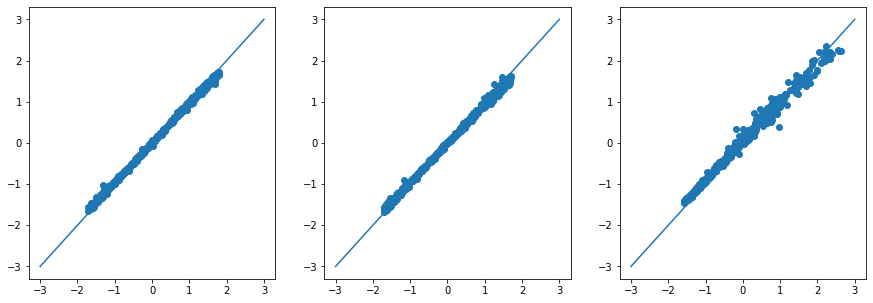

In [105]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.scatter(a_ans_test, a_pred_test)
plt.plot([-3,3],[-3,3])
plt.subplot(1,3,2)
plt.scatter(b_ans_test, b_pred_test)
plt.plot([-3,3],[-3,3])
plt.subplot(1,3,3)
plt.scatter(c_ans_test, c_pred_test)
plt.plot([-3,3],[-3,3])

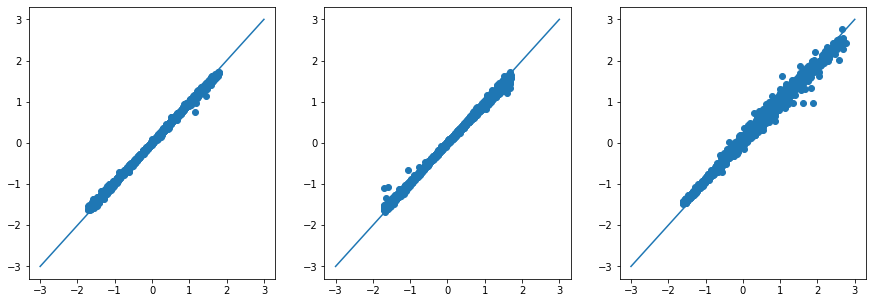

In [106]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.scatter(a_ans_train, a_pred_train)
plt.plot([-3,3],[-3,3])
plt.subplot(1,3,2)
plt.scatter(b_ans_train, b_pred_train)
plt.plot([-3,3],[-3,3])
plt.subplot(1,3,3)
plt.scatter(c_ans_train, c_pred_train)
plt.plot([-3,3],[-3,3])

# Save model

In [62]:
cnn_model.save('GazeTracking_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: GazeTracking_model\assets


# Load model

In [114]:
loaded_model = keras.models.load_model("GazeTracking_model_5")

In [99]:
EPOCH = 300
learning_rate = 0.0005
decay_rate = learning_rate / EPOCH 
optimizer = tf.keras.optimizers.Adam(lr=learning_rate,decay=decay_rate) 
loaded_model.compile(loss='mae',optimizer=optimizer,metrics=['mae'])

loaded_model.fit(
    x = x_train, 
    y = y_train,
    batch_size=64, 
    epochs=EPOCH,
    shuffle=True,
    validation_data=(x_test, y_test))

Epoch 1/300
32/32 [==============================] - 266s 8s/step - loss: 0.0950 - mae: 0.0832 - val_loss: 0.0630 - val_mae: 0.0512
Epoch 2/300
32/32 [==============================] - 268s 8s/step - loss: 0.0947 - mae: 0.0830 - val_loss: 0.0612 - val_mae: 0.0496
Epoch 3/300
32/32 [==============================] - 261s 8s/step - loss: 0.0949 - mae: 0.0832 - val_loss: 0.0663 - val_mae: 0.0547
Epoch 4/300
32/32 [==============================] - 259s 8s/step - loss: 0.0958 - mae: 0.0842 - val_loss: 0.0565 - val_mae: 0.0449
Epoch 5/300
32/32 [==============================] - 260s 8s/step - loss: 0.0933 - mae: 0.0818 - val_loss: 0.0590 - val_mae: 0.0475
Epoch 6/300
32/32 [==============================] - 261s 8s/step - loss: 0.0928 - mae: 0.0813 - val_loss: 0.0575 - val_mae: 0.0460
Epoch 7/300
32/32 [==============================] - 261s 8s/step - loss: 0.0932 - mae: 0.0816 - val_loss: 0.0670 - val_mae: 0.0555
Epoch 8/300
32/32 [==============================] - 260s 8s/step - loss: 0.

KeyboardInterrupt: 

In [100]:
loaded_model.save('GazeTracking_model_5')

INFO:tensorflow:Assets written to: GazeTracking_model_5\assets


In [217]:
def data_preparation(file):
    json_fns = glob(file + "//*.json")
    all_y = np.zeros((len(json_fns), 3))
    all_x = np.zeros((len(json_fns), 384, 512, 3))
    i = 0
    for json_fn in json_fns:
        img = cv2.imread("%s.jpg"%json_fn[:-5])
        all_x[i,:,:,:] = img / 255
        data = json.load(open(json_fn))
        look_vec = list(eval(data['eye_details']['look_vec']))
        look_vec[1] = -look_vec[1]
        all_y[i,:] = look_vec[:3]
        i = i + 1
    return all_x, all_y

def predict_external(model_path, x, y, loss):
    loaded_model = keras.models.load_model(model_path)
    prediction = loaded_model.predict(x)
    return loss(y,prediction).numpy(), prediction


In [218]:
base_path = "C:\\Users\\chini\\Downloads\\UnityEyes_Windows\\UnityEyes_Windows\\imgs"
MyX, MyY = data_preparation(base_path)
scaled_MyY = (MyY - mean_) / std_
loss_val, prediction = predict_external("GazeTracking_model_5", MyX, scaled_MyY, tf.keras.losses.MeanAbsoluteError())